![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

# Project 3: Web APIs & NLP

# Problem Statement

To identify the right subreddit given a specific post¶

### Contents:

1. Background
2. Importing Libraries
3. Web Scraping
4. Data Exploration
5. Pre Processing
6. Modeling
7. Evaluation
8. Conclusion

# 1. Background

Using Pushshift's API, I will collect posts from two subreddits which are from 'NBA' and 'PremierLeague'. I will then use NLP to train a classifier on which subreddit a given post came from. Two models will be created and compared where I will be using Naive Bayes and Random Forest classifier.

# 2. Import Libraries

In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, plot_roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 3. Web Scraping

##### Created a function to scrape subreddit APIs

In [2]:
def scraping(subreddit, number_of_times_to_scrape, no_of_posts_to_scrape):
    title_list = []
    author_list = []
    created_utc_list = []
    
    url = 'https://api.pushshift.io/reddit/search/submission'
    req = requests.get(url, params = {'subreddit': subreddit,
                                      'size': no_of_posts_to_scrape
                                     })
    data = req.json()
    
    for item in data['data']:
        title_list.append(item['title'])
    for item in data['data']:
        author_list.append(item['author'])
    for item in data['data']:
        created_utc_list.append(item['created_utc'])
        
    for i in range(1, number_of_times_to_scrape):
        url = 'https://api.pushshift.io/reddit/search/submission'
        req = requests.get(url, params = {'subreddit': subreddit,
                                          'size': no_of_posts_to_scrape,
                                          'before': created_utc_list[(len(created_utc_list)) - 1]
                                         })
    
        data = req.json()
        
        for item in data['data']:
            title_list.append(item['title'])
        for item in data['data']:
            author_list.append(item['author'])
        for item in data['data']:
            created_utc_list.append(item['created_utc'])
    
    output = pd.DataFrame({'Title':title_list, 'Author':author_list, 'Created_utc':created_utc_list})
    output.drop_duplicates(subset = 'Title', keep = 'first', inplace = True)
    return output

In [3]:
#def scraping(subreddit, number_of_times_to_scrape, no_of_posts_to_scrape)
subreddit1 = scraping('nba', 50, 100)

In [4]:
#def scraping(subreddit, number_of_times_to_scrape, no_of_posts_to_scrape)
subreddit2 = scraping('PremierLeague', 50, 100)

# 4. Data Exploration

In [5]:
print(len(subreddit1))
print(len(subreddit2))

4737
4761


In [6]:
subreddit1.head()

,Title,Author,Created_utc
0,I am seeking for a submissive that’s ready to ...,goddespiper8809,1633167249
1,Good News Friday: NBA players and other unexpe...,christoneforlife,1633161227
2,"Players Are Easy, But Can You Make It Through ...",SilasSandra,1633158554
3,"Which team will win, (hypothetically) a team (...",Litasf22,1633158048
4,The problem with ESPN analysts is that they ar...,killedBySasquatch,1633157903


In [7]:
subreddit2.head()

,Title,Author,Created_utc
0,What do rival fans think about Tomiyasu?,MajorAffectionate595,1633165996
1,Which team from the middle or bottom half of t...,MajorAffectionate595,1633165890
2,Liverpool vs Manchester City - Preliminary View,-y-o-l-o-,1633165768
3,PREMIER LEAGUE FIXTURES - Matchday 7,wm17,1633150865
4,PREMIER LEAGUE MARBLES - Matchday 7 ⚽️🏟,wm17,1633150638


In [8]:
print(subreddit1.nunique())
print(subreddit2.nunique())

Title          4737
Author         2133
Created_utc    4725
dtype: int64
Title          4761
Author         2435
Created_utc    4760
dtype: int64


In [9]:
#Search for null values
print(subreddit1.isnull().sum())
print(subreddit2.isnull().sum())

Title          0
Author         0
Created_utc    0
dtype: int64
Title          0
Author         0
Created_utc    0
dtype: int64


## 4.1 Combine both subreddits into Dataframe

In [10]:
subreddit1['Label'] = 1
subreddit2['Label'] = 0

In [11]:
frames = [subreddit1, subreddit2]

In [12]:
subreddit_data = pd.concat(frames)

In [13]:
subreddit_data.nunique()

Title          9494
Author         4547
Created_utc    9479
Label             2
dtype: int64

In [14]:
subreddit_data.head()

,Title,Author,Created_utc,Label
0,I am seeking for a submissive that’s ready to ...,goddespiper8809,1633167249,1
1,Good News Friday: NBA players and other unexpe...,christoneforlife,1633161227,1
2,"Players Are Easy, But Can You Make It Through ...",SilasSandra,1633158554,1
3,"Which team will win, (hypothetically) a team (...",Litasf22,1633158048,1
4,The problem with ESPN analysts is that they ar...,killedBySasquatch,1633157903,1


In [15]:
# Ensure correct number of posts for each subreddit
subreddit_data['Label'].value_counts()

0    4761
1    4737
Name: Label, dtype: int64

#### Save the DataFrame to CSV

In [16]:
subreddit_data.to_csv('subreddits.csv')

# 5. Pre Processing

## 5.1 Tokenize

In [17]:
subreddit_data = pd.read_csv('subreddits.csv')

In [49]:
subreddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9498 entries, 0 to 9497
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                9498 non-null   int64 
 1   Title                     9498 non-null   object
 2   Author                    9498 non-null   object
 3   Created_utc               9498 non-null   int64 
 4   Label                     9498 non-null   int64 
 5   Tokenized                 9498 non-null   object
 6   Tokenized and Lemmatized  9498 non-null   object
dtypes: int64(3), object(4)
memory usage: 519.5+ KB


In [18]:
def tokenize(subreddit_data):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(subreddit_data)

In [19]:
subreddit_data['Tokenized'] = subreddit_data['Title'].map(tokenize)

## 5.2 Lemmatize

In [20]:
def lemmatize(subreddit_data):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(i) for i in subreddit_data])

In [21]:
subreddit_data['Tokenized and Lemmatized'] = subreddit_data['Tokenized'].map(lemmatize)

In [22]:
subreddit_data.head()

,Unnamed: 0,Title,Author,Created_utc,Label,Tokenized,Tokenized and Lemmatized
0,0,I am seeking for a submissive that’s ready to ...,goddespiper8809,1633167249,1,"[I, am, seeking, for, a, submissive, that, s, ...",I am seeking for a submissive that s ready to ...
1,1,Good News Friday: NBA players and other unexpe...,christoneforlife,1633161227,1,"[Good, News, Friday, NBA, players, and, other,...",Good News Friday NBA player and other unexpect...
2,2,"Players Are Easy, But Can You Make It Through ...",SilasSandra,1633158554,1,"[Players, Are, Easy, But, Can, You, Make, It, ...",Players Are Easy But Can You Make It Through T...
3,3,"Which team will win, (hypothetically) a team (...",Litasf22,1633158048,1,"[Which, team, will, win, hypothetically, a, te...",Which team will win hypothetically a team 5 MI...
4,4,The problem with ESPN analysts is that they ar...,killedBySasquatch,1633157903,1,"[The, problem, with, ESPN, analysts, is, that,...",The problem with ESPN analyst is that they are...


# 6. Modeling

In [23]:
X = subreddit_data[['Tokenized and Lemmatized']]
y = subreddit_data['Label']

In [24]:
#Baseline Accuracy
y.value_counts(normalize=True)

0    0.501263
1    0.498737
Name: Label, dtype: float64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

In [26]:
X_train.head()

,Tokenized and Lemmatized
4928,Kane showing Levy who is the real bos Good on ...
8214,I Make Concept Kits for football manager here ...
7757,Confused about Man City s transfer tactic
5293,Best place to play worst place to live
2614,Classic Penny Hardaway commercial ft Chris Roc...


In [27]:
#1 = nba, 0 = PremierLeague
y_train.head()

4928    0
8214    0
7757    0
5293    0
2614    1
Name: Label, dtype: int64

In [28]:
# Instantiate CountVectorizer.
cvec = CountVectorizer(max_features = 1500, stop_words = 'english')

In [29]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['Tokenized and Lemmatized']).todense(),
                          columns = cvec.get_feature_names())

In [30]:
X_train_cvec.head()

,000,10,100,100m,11,12,13,14,15,16,...,yes,yesterday,york,young,youngster,youtube,zach,zion,zouma,уou
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


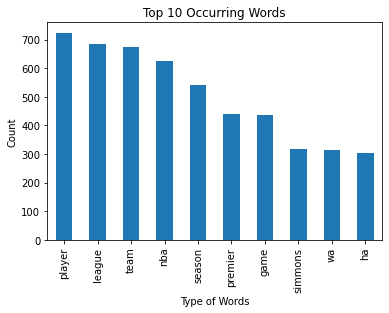

In [31]:
# Plot top 10 occuring words
bar_plot = X_train_cvec.sum().sort_values(ascending = False).head(10)
bar_plot.plot(kind = 'bar', title = 'Top 10 Occurring Words', xlabel = 'Type of Words', ylabel = 'Count');

In [32]:
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['Tokenized and Lemmatized']).todense(),
                         columns = cvec.get_feature_names())

## 6.1 Naive Bayes

In [33]:
nb = MultinomialNB()

In [34]:
# Fit our model
nb_model = nb.fit(X_train_cvec, y_train)

In [35]:
# Generate our predictions
predictions_nb = nb_model.predict(X_test_cvec)

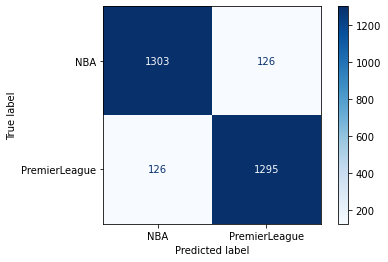

In [36]:
# Plot confusion matrix
plot_confusion_matrix(nb_model, X_test_cvec, y_test, cmap = 'Blues', display_labels = ['NBA','PremierLeague']);

In [37]:
# Check for over or under fitting
print(nb_model.score(X_train_cvec, y_train))
print(nb_model.score(X_test_cvec, y_test))

0.9259927797833934
0.911578947368421


In [38]:
print(f'F1 Score:',f1_score(y_test, predictions_nb).round(3))
print(f'Accuracy Score:',accuracy_score(y_test, predictions_nb).round(3))

F1 Score: 0.911
Accuracy Score: 0.912


##### Plot Countplot to visualize how Naive Bayes model predicts. Based on baseline accuracy, we should have almost equal predictions for both subreddits

/Users/ben/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


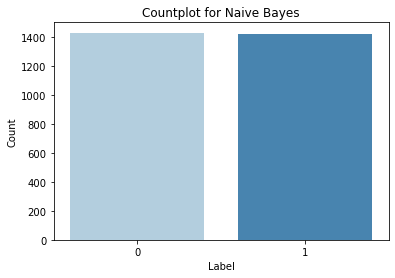

In [39]:
ax = sns.countplot(predictions_nb, palette = 'Blues')
ax.set(xlabel = "Label", ylabel = "Count", title = 'Countplot for Naive Bayes');

## 6.2 Random Forest Classifier 

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

In [41]:
#Instatiate RandomForestClassifier
rfc = RandomForestClassifier(oob_score = True, n_jobs = -1)

In [42]:
rfc_params = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3]
}
gs = GridSearchCV(rfc, param_grid = rfc_params, cv = 5, n_jobs = -1)
gs.fit(X_train_cvec, y_train)
print(gs.best_score_)
gs.best_params_

0.8452188032157142


{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}

In [43]:
predictions_rfc = gs.predict(X_test_cvec)
print(len(predictions_rfc))

2850


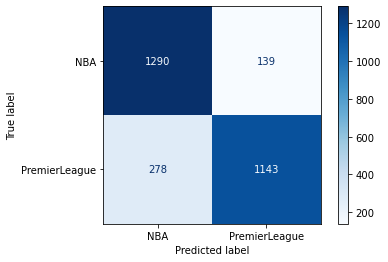

In [44]:
plot_confusion_matrix(gs, X_test_cvec, y_test, cmap = 'Blues', values_format = 'd', display_labels=['NBA','PremierLeague']);

In [45]:
# Check for over or under fitting
print(gs.score(X_train_cvec, y_train))
print(gs.score(X_test_cvec, y_test))

0.8614620938628159
0.8536842105263158


In [46]:
print(f'F1 Score:', f1_score(y_test, predictions_rfc).round(3))
print(f'Accuracy Score:', accuracy_score(y_test, predictions_rfc).round(3))

F1 Score: 0.846
Accuracy Score: 0.854


##### Plot Countplot to visualize how Random Forest Classifier model predicts. Based on baseline accuracy, we should have almost equal predictions for both subreddits

/Users/ben/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


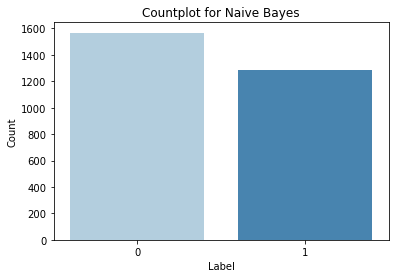

In [47]:
ax = sns.countplot(predictions_rfc, palette = 'Blues')
ax.set(xlabel = "Label", ylabel = "Count", title = 'Countplot for Naive Bayes');

# 7. Evaluation

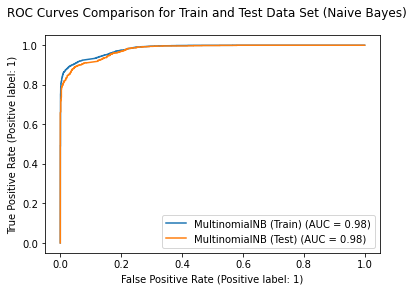

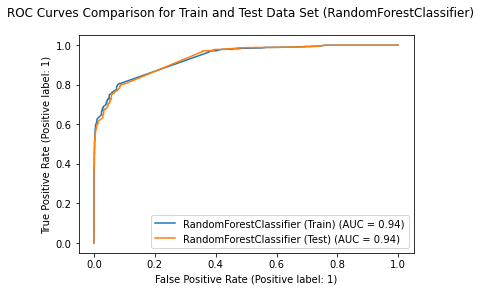

In [48]:
# Plot AUC - ROC Curve

fig = plot_roc_curve(nb_model, X_train_cvec, y_train, name = 'MultinomialNB (Train)')
fig = plot_roc_curve(nb_model, X_test_cvec, y_test, name = 'MultinomialNB (Test)', ax = fig.ax_)
fig.figure_.suptitle("ROC Curves Comparison for Train and Test Data Set (Naive Bayes)")
plt.show()

fig = plot_roc_curve(gs, X_train_cvec, y_train, name = 'RandomForestClassifier (Train)')
fig = plot_roc_curve(gs, X_test_cvec, y_test, name = 'RandomForestClassifier (Test)', ax = fig.ax_)
fig.figure_.suptitle("ROC Curves Comparison for Train and Test Data Set (RandomForestClassifier)")
plt.show()

# 8. Conclusion

Based on the two models, Naive Bayes is the better model with higher F1 score, accuracy score and AUC value. However for consistency wise, Random Forest Classifier is a better fitted model from the look of the ROC Curve. Future work including tring out the TF-IDF Vectorizer to test for a more accurate model. I will also be removing majority of the common words which have high freqeuncy of occurrences. Other models like Logistic Regression, SVM, etc will be use as well, to further compare and decide on the best model for this binary classification.